In [15]:
import os
import torch
import shutil
import random
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import DataLoader, random_split

from tqdm import tqdm
from copy import deepcopy
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.nn import CrossEntropyLoss

In [2]:
from models.resnet import resnet18

In [3]:
def get_device():
    if torch.cuda.is_available():
        device = torch.device("cuda")
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
    return device

device = get_device()
print(f"device is: {device}")

device is: mps


#### Create Datasets

In [4]:
def create_dataset_directory(src_dir = "./data/test", dst_root = "./data/test"):
    os.makedirs(dst_root, exist_ok=True)
    img_exts = {'.jpg'}

    for filename in os.listdir(src_dir):
        if not any(filename.lower().endswith(ext) for ext in img_exts):
            continue 
        prefix = filename.split('_')[0]
        target_dir = os.path.join(dst_root, prefix)
        os.makedirs(target_dir, exist_ok=True)

        src_path = os.path.join(src_dir, filename)
        dst_path = os.path.join(target_dir, filename)
        
        shutil.move(src_path, dst_path)
    print("directory structure created")

create_dataset_directory(src_dir = "./data/test", dst_root = "./data/test")
create_dataset_directory(src_dir = "./data/train", dst_root = "./data/train")

directory structure created
directory structure created


In [5]:
# increase the test dataset size. 
def move_into_test(test_dir = "data/test", train_dir = "data/train"):
    if not os.path.exists(train_dir) or not os.path.exists(test_dir):
        raise FileNotFoundError("Ensure both 'data/train' and 'data/test' directories exist.")

    for class_name in os.listdir(train_dir):
        train_class_path = os.path.join(train_dir, class_name)
        test_class_path = os.path.join(test_dir, class_name)

        if not os.path.isdir(train_class_path):
            continue  

        if not os.path.exists(test_class_path):
            os.makedirs(test_class_path)  # Create target class folder if missing

        files = os.listdir(train_class_path)
        files = [f for f in files if os.path.isfile(os.path.join(train_class_path, f))]

        if len(files) < 300:
            print(f"Skipping {class_name}: not enough files to move.")
            continue

        files_to_move = random.sample(files, 300)

        for file_name in files_to_move:
            src_path = os.path.join(train_class_path, file_name)
            dst_path = os.path.join(test_class_path, file_name)
            shutil.move(src_path, dst_path)
        print(f"moved 300 files from '{class_name}' train to test.")

# run this code only once
# move_into_test()


In [6]:
root_train = './data/train'
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

root_test = './data/test'
test_transform = transforms.Compose([
transforms.Resize((224, 224)),
transforms.ToTensor(),
transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

test_set = datasets.ImageFolder(root_test, transform = test_transform)
train_dataset = datasets.ImageFolder(root_train, transform = train_transform)


train_size = int(0.80 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_set, val_set= random_split(train_dataset, [train_size, val_size])
val_set.dataset.transform = test_transform # change transforms for val/test

In [7]:
val_loader = DataLoader(val_set, batch_size=1024)
test_loader = DataLoader(test_set, batch_size=1024)
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)

#### Utility Functions

In [8]:
def save_checkpoint(model, checkpoint):
    torch.save(model.state_dict(), checkpoint)

def validate(model, val_loader, loss_fn = CrossEntropyLoss()):
    model.eval()
    with torch.inference_mode():
        N = 0
        mean_loss = 0
    
        for x, y in val_loader:
            x = x.to(device)
            y = y.to(device)

            outputs = model(x)
            loss = loss_fn(outputs, y)

            N += len(x)
            mean_loss += len(x) * (loss.item() - mean_loss)/N         
    return mean_loss


def accuracy(model, data_loader):
    model.eval()
    with torch.inference_mode():
      total = 0
      correct = 0
      for x, y in data_loader:
        x = x.to(device)
        y = y.to(device)

        output = model(x)
        prob = torch.softmax(output, dim = 1)
        pred = prob.max(dim = 1, keepdim = True)[1]
        correct += pred.eq(y.view_as(pred)).sum().item()
        total += len(y)
    acc = correct/total
    return acc

#### Training Module

In [9]:
def train(model, train_loader, val_loader, checkpoint, learning_rate = 0.01, epochs=20):
    
    loss_fn = CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    # scheduler = MultiStepLR(optimizer, milestones=[10], gamma=0.1)
    val_loss_list = []

    #acc and loss before training
    val_loss = validate(model, val_loader)
    val_loss_list.append(val_loss)
    best_loss = val_loss
    best_model = deepcopy(model)
    print(f"validation loss prior to training: {val_loss:.4f}")
    
    for epoch in tqdm(range(0, epochs)):
        model.train()
        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)

            outputs = model(x)
            loss = loss_fn(outputs, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # scheduler.step()
        #acc and loss 
        model.eval()
        val_loss = validate(model, val_loader)

        val_loss_list.append(val_loss)

        if best_loss > val_loss:
            best_loss = val_loss
            best_model = deepcopy(model)
            save_checkpoint(model, checkpoint)
        print(f"val loss : {val_loss:.4f}")

    return best_model, val_loss_list


In [ ]:
def get_resnet18(num_classes = 29, pretrained=False):
    model = resnet18(pretrained)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model = model.to(device)
    return model
model = get_resnet18(num_classes=29, pretrained=True)
model_path = 'resnet18.pth' 
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path, map_location='cpu'))
else:
    model, val_loss_list = train(model, train_loader, val_loader, 'resnet18.pth')
    np.save('val_loss.npy', val_loss_list)
    save_checkpoint(model, 'resnet18.pth')

validation loss prior to training: 3.5746


  5%|▌         | 1/20 [04:00<1:16:10, 240.55s/it]

val loss : 0.3489


 10%|█         | 2/20 [08:13<1:14:16, 247.58s/it]

val loss : 0.0827


 15%|█▌        | 3/20 [12:45<1:13:24, 259.08s/it]

val loss : 0.1216


 20%|██        | 4/20 [17:11<1:09:48, 261.78s/it]

val loss : 0.0218


 25%|██▌       | 5/20 [21:09<1:03:17, 253.14s/it]

val loss : 0.1350


 30%|███       | 6/20 [25:14<58:23, 250.26s/it]  

val loss : 0.0657


 35%|███▌      | 7/20 [29:31<54:41, 252.45s/it]

val loss : 0.0090


 40%|████      | 8/20 [33:49<50:51, 254.32s/it]

val loss : 0.2134


 45%|████▌     | 9/20 [37:59<46:24, 253.12s/it]

val loss : 0.0436


 50%|█████     | 10/20 [42:04<41:45, 250.54s/it]

val loss : 0.0161


 55%|█████▌    | 11/20 [46:08<37:15, 248.41s/it]

val loss : 0.0414


 60%|██████    | 12/20 [50:02<32:32, 244.08s/it]

val loss : 2.0175


 65%|██████▌   | 13/20 [53:58<28:11, 241.70s/it]

val loss : 0.0007


 70%|███████   | 14/20 [57:52<23:55, 239.33s/it]

val loss : 0.0085


 75%|███████▌  | 15/20 [1:01:43<19:44, 236.92s/it]

val loss : 0.0002


 80%|████████  | 16/20 [1:05:40<15:47, 236.95s/it]

val loss : 1.1287


 85%|████████▌ | 17/20 [1:09:36<11:49, 236.56s/it]

val loss : 0.0008


 90%|█████████ | 18/20 [1:13:30<07:51, 235.90s/it]

val loss : 0.0000


 95%|█████████▌| 19/20 [1:17:25<03:55, 235.43s/it]

val loss : 0.0013


100%|██████████| 20/20 [1:21:18<00:00, 243.92s/it]

val loss : 0.0001


#### Visualize loss curve

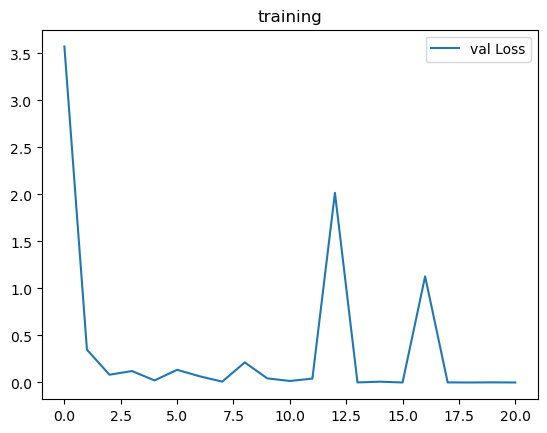

In [16]:
val_loss_list = np.load('val_loss.npy')
plt.plot(val_loss_list, label='val Loss')
plt.legend()
plt.title("training")
plt.show()

#### visualize features

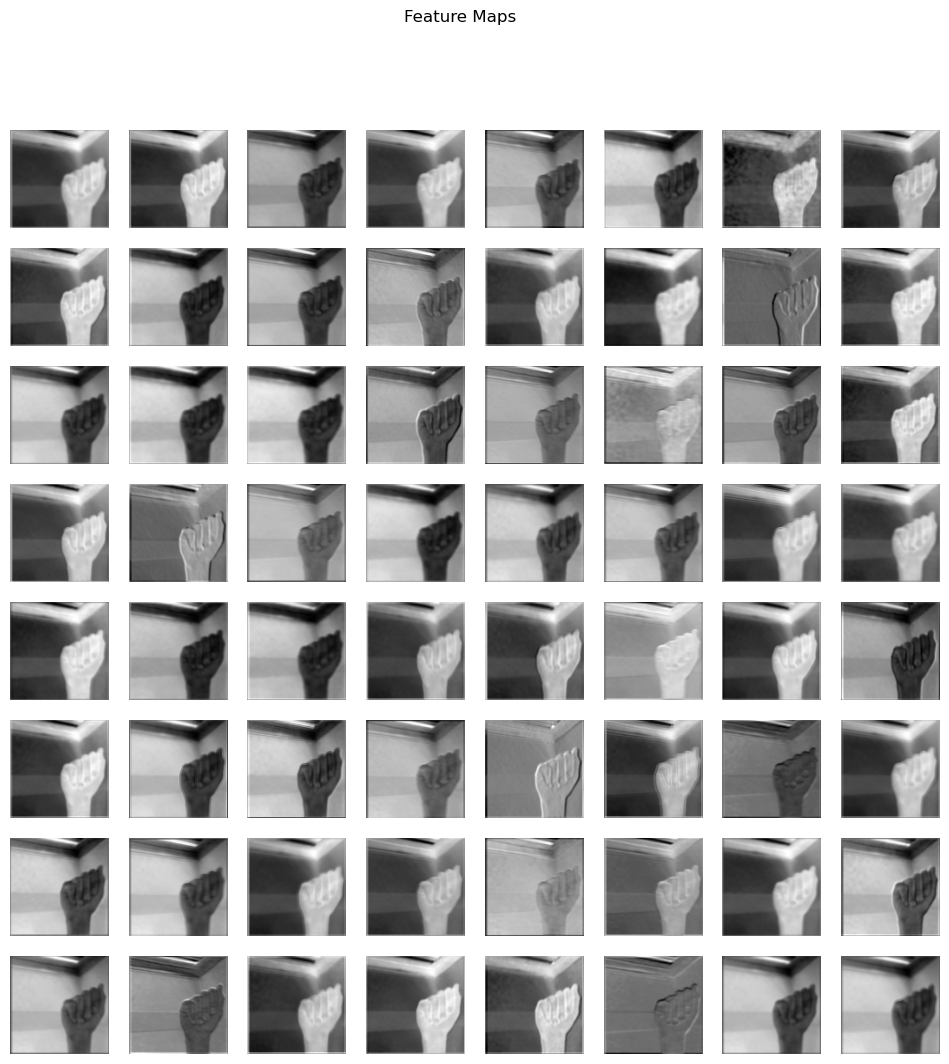

In [17]:
def visualize_feature_maps(model, layer, image_tensor):
    def hook_fn(module, input, output):
        plt.figure(figsize=(12, 12))
        for i in range(min(64, output.size(1))):
            plt.subplot(8, 8, i + 1)
            plt.imshow(output[0, i].detach().cpu().numpy(), cmap='gray')
            plt.axis('off')
        plt.suptitle("Feature Maps")
        plt.show()

    handle = layer.register_forward_hook(hook_fn)
    _ = model(image_tensor.unsqueeze(0).to(device))
    handle.remove()

image, _ = test_set[0]
visualize_feature_maps(model, model.conv1, image)

#### evaluate trained model

In [13]:
test_accuracy = accuracy(model, test_loader)
print(f"test accuracy of trafined model is: {test_accuracy*100:.2f}")

test accuracy of trafined model is: 100.00


In [14]:
val_accuracy = accuracy(model, val_loader)
print(f"val accuracy of trafined model is: {val_accuracy*100:.2f}")

val accuracy of trafined model is: 100.00
